All imports

In [157]:
import os
import pandas as pd
import librosa
import sklearn
from sklearn.preprocessing import MinMaxScaler
import random
from random import shuffle
import itertools
import matplotlib.pyplot as plt
from importlib import reload
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report, accuracy_score
import seaborn as sns

scaler = MinMaxScaler(feature_range=(-1,1))
plt=reload(plt)

# Step 1: Split data

In [158]:
# path = "C:/Users/avamc_srsebwe\OneDrive - University of Florida/Spring '23/CIS4930-ML/p3/data_folder/"
# random.seed(8)
# def ReadAndSplit(filepath):
#     files = {}
#     j = 0
#     for i in os.listdir(filepath):
#         files[j] = librosa.load(filepath + "/" +i)
#         j = j+1
#     shuffle(files)
#     return dict(itertools.islice(files.items(), 0, 70)), dict(itertools.islice(files.items(), 70, 100))

# angry_train, angry_test = ReadAndSplit(path+"/angry")
# fear_train, fear_test = ReadAndSplit(path+"/fear")
# happy_train, happy_test = ReadAndSplit(path+"/happy")
# sad_train, sad_test = ReadAndSplit(path+"/sad")

In [159]:
path = "C:/Users/avamc_srsebwe\OneDrive - University of Florida/Spring '23/CIS4930-ML/p3/data_folder/"
random.seed(8)
def ReadAndSplit(filepath):
    files = {}
    j = 0
    for i in os.listdir(filepath):
        files[j] = librosa.load(filepath + "/" +i)
        j = j+1
    return dict(files)

angry = ReadAndSplit(path+"/angry")
fear = ReadAndSplit(path+"/fear")
happy = ReadAndSplit(path+"/happy")
sad = ReadAndSplit(path+"/sad")

In [160]:
signal, sample_rate = librosa.load(path+"/angry/YAF_merge_angry.wav")
print(signal)

[ 1.02944705e-05 -9.50715330e-05 -2.62221263e-04 ...  3.89825320e-04
  3.46743793e-04 -4.80794224e-05]


In [161]:
print(sample_rate)

22050


# Step 2: Exploratory Data Analysis

#### Label Distribution is going to be even since there are 100 files for each emotion

#### Plotting Loudness

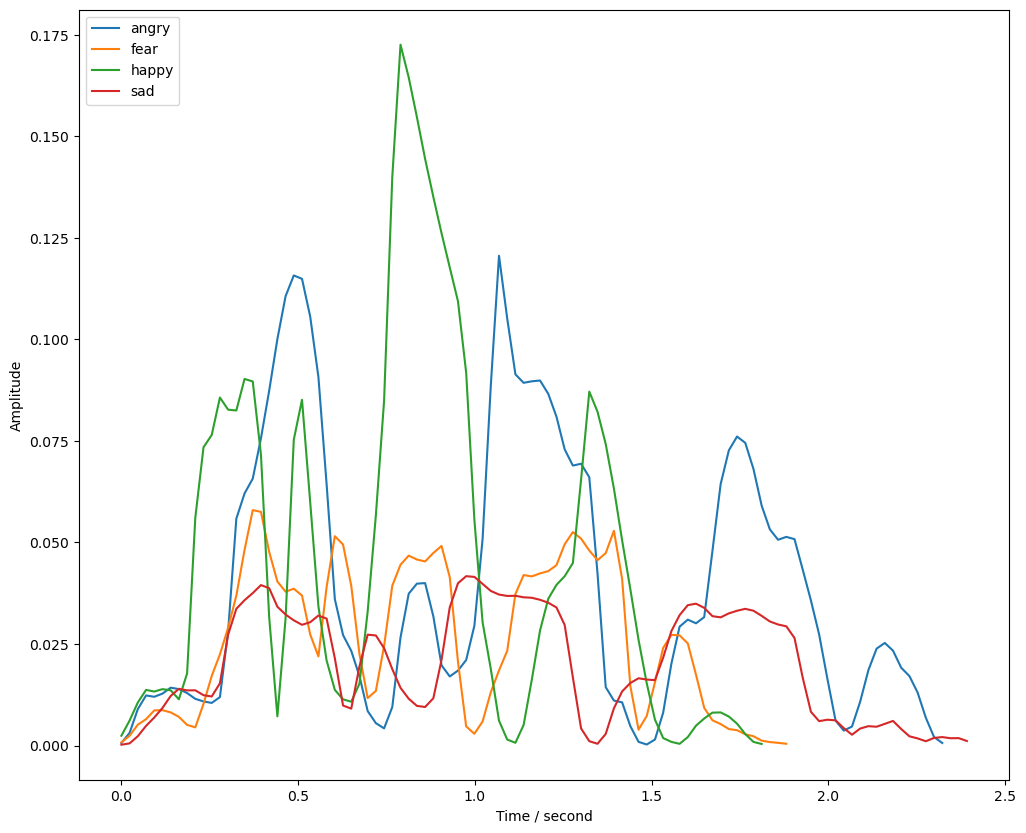

In [162]:
def plot(title, dict):
    df_loudness = pd.DataFrame()
    S, phase = librosa.magphase(librosa.stft(dict[0][0]))
    rms = librosa.feature.rms(S=S)
    #print(rms[0])
    df_loudness['Loudness'] = rms[0]
    #print(df_loudness.head(5))
    plt.figure(1)
    times = librosa.times_like(rms)
    plt.plot(times, rms[0], label=title)
    plt.xlabel("Time / second")
    plt.ylabel("Amplitude")
    #plt.show()
    #return plt
    
plt.figure(figsize=(12,10))
plot("angry", angry)
plot("fear", fear)
plot("happy", happy)
plot("sad", sad)
plt.legend(loc="upper left")
plt.show()

### Plot Audio Files in Time Domain

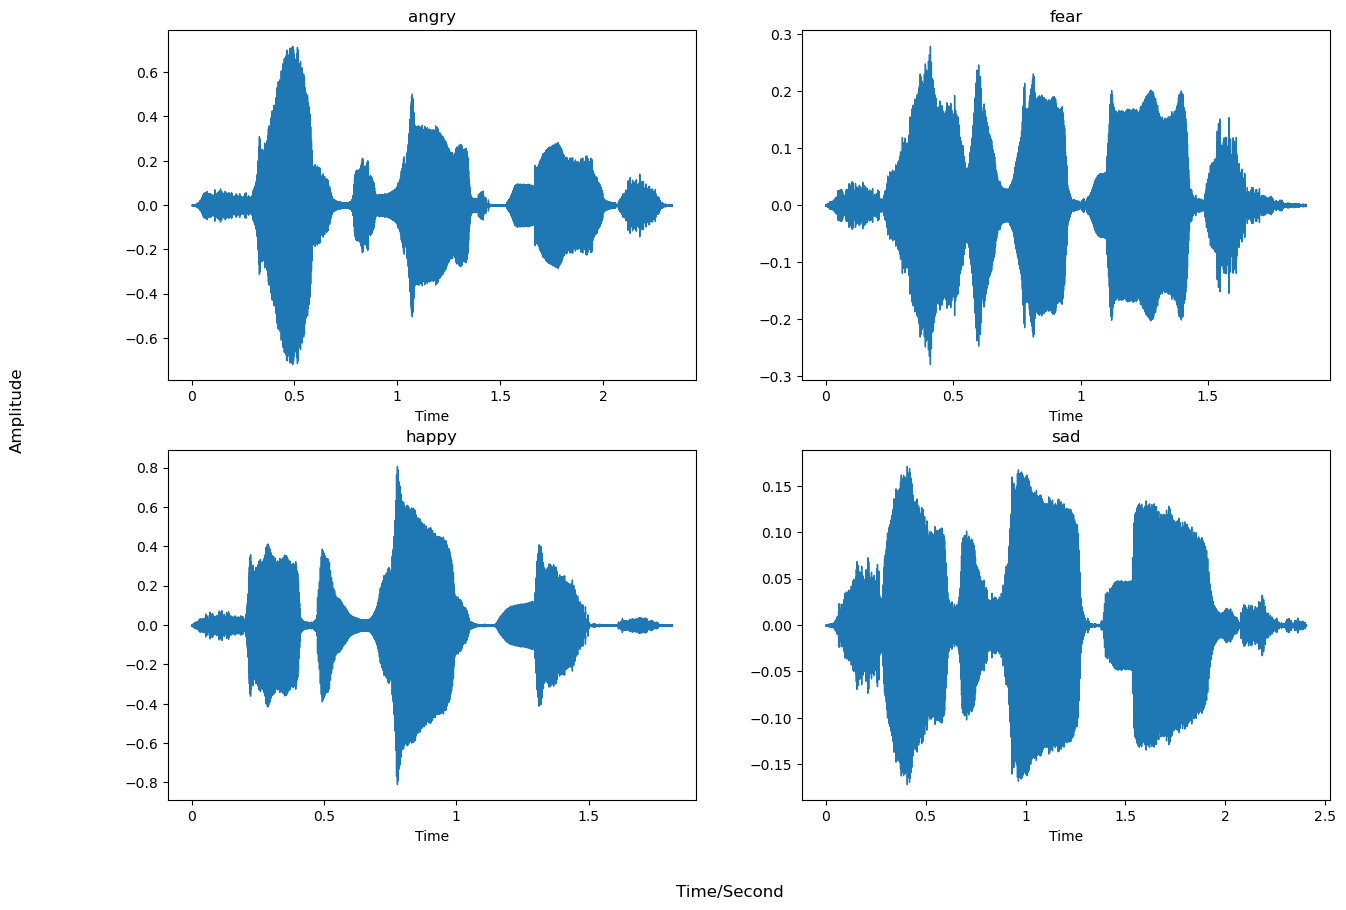

In [163]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(15,10))
fig.supxlabel("Time/Second")
fig.supylabel("Amplitude")

ax1[0].set_title("angry")
librosa.display.waveshow(angry[0][0], sr=angry[0][1], ax=ax1[0])
ax1[1].set_title("fear")
librosa.display.waveshow(fear[0][0], sr=fear[0][1], ax=ax1[1])
ax2[0].set_title("happy")
librosa.display.waveshow(happy[0][0], sr=happy[0][1], ax=ax2[0])
ax2[1].set_title("sad")
librosa.display.waveshow(sad[0][0], sr=sad[0][1], ax=ax2[1])

### Plot Audio Files in Frequency Domain

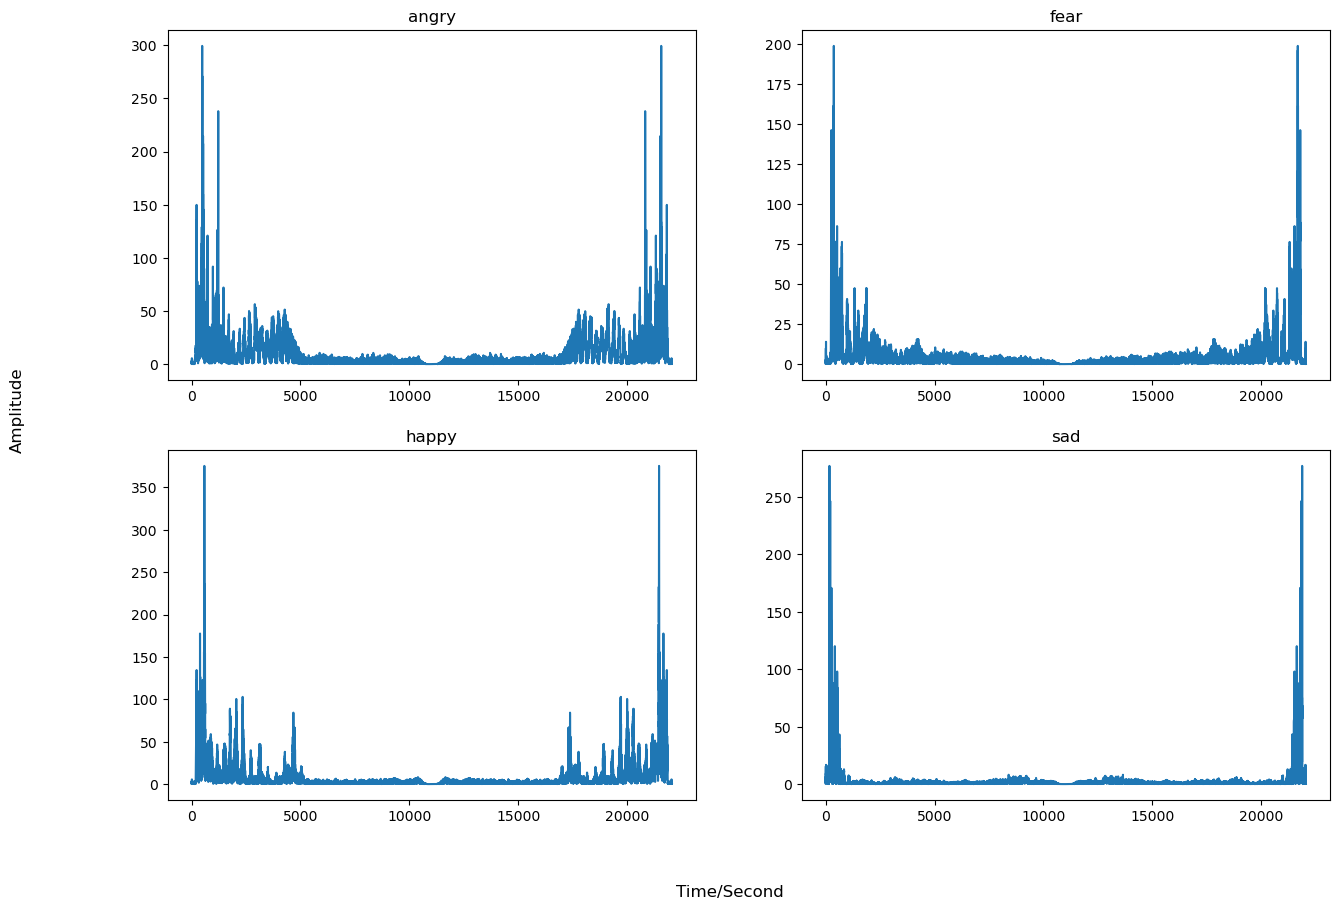

In [164]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(15,10))
fig.supxlabel("Time/Second")
fig.supylabel("Amplitude")

def plot(title, dict, ax):
    k = np.arange(len(dict[0][0]))
    T = len(dict[0][0])/dict[0][1]
    freq = k/T

    DATA_0 = np.fft.fft(dict[0][0])
    abs_DATA_0 = abs(DATA_0)
    
    ax.set_title(title)
    ax.plot(freq, abs_DATA_0)

    
plot("angry", angry, ax1[0])
plot("fear", fear, ax1[1])
plot("happy", happy, ax2[0])
plot("sad", sad, ax2[1])
plt.show()


### Plot the time-frequency variation of the audio

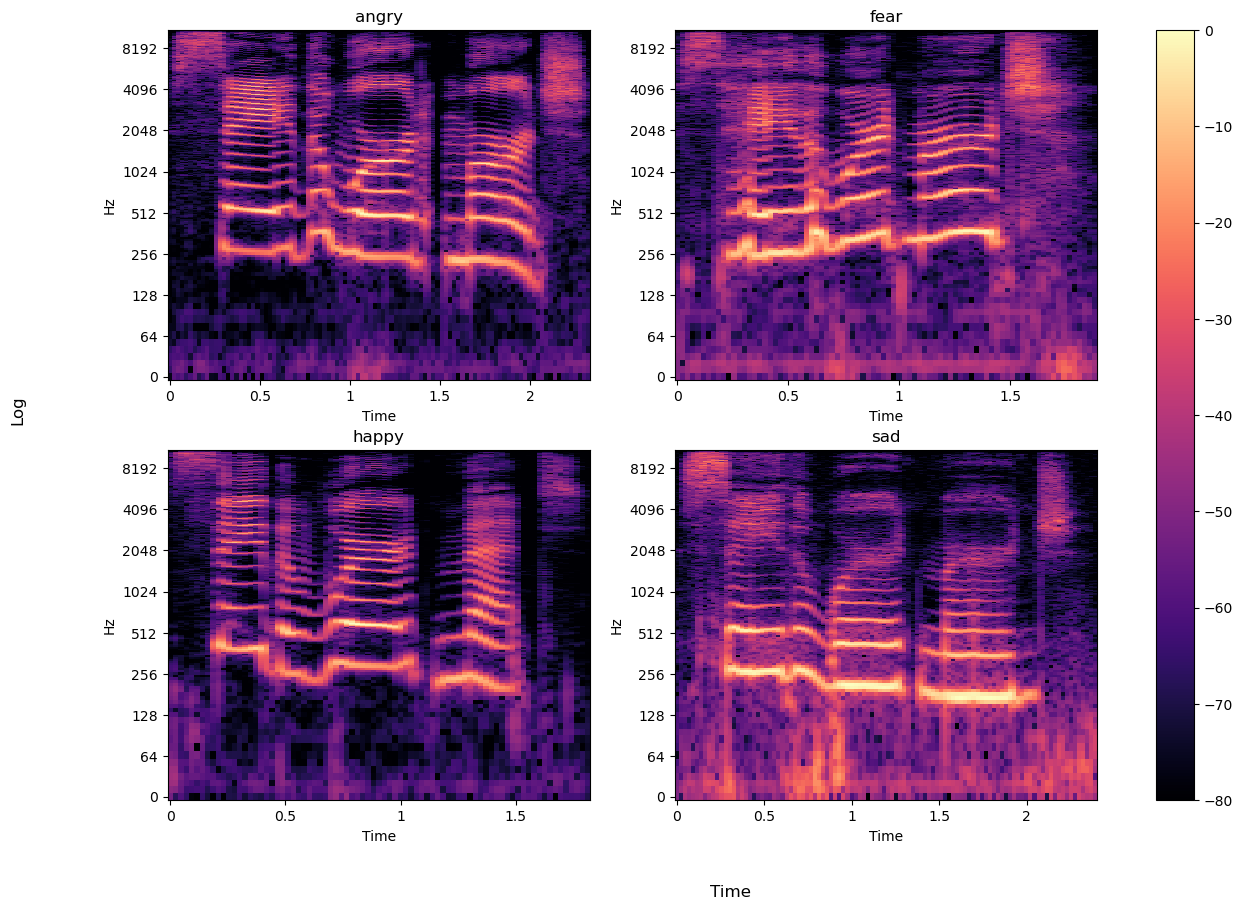

In [165]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(15,10))
fig.supxlabel("Time")
fig.supylabel("Log")

ax1[0].set_title("angry")
S_db = librosa.amplitude_to_db(np.abs(librosa.stft(angry[0][0])), ref=np.max)
librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax1[0])
ax1[1].set_title("fear")
S_db = librosa.amplitude_to_db(np.abs(librosa.stft(fear[0][0])), ref=np.max)
librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax1[1])
ax2[0].set_title("happy")
S_db = librosa.amplitude_to_db(np.abs(librosa.stft(happy[0][0])), ref=np.max)
librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax2[0])
ax2[1].set_title("sad")
S_db = librosa.amplitude_to_db(np.abs(librosa.stft(sad[0][0])), ref=np.max)
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax2[1])

fig.colorbar(img, ax=[ax1[0], ax1[1], ax2[0], ax2[1]])

# Step 3: Accoustic Feature Extraction

1. Zero Crossing Rate - rate of sign-changes of the signal during the duration of a particular frame
2. Energy - sum of squares of the signal values, normalized by the respective frame length
3. MFCC - Mel Freq Cepstral Coefficients form a cepstral representation where the freq bands are not linear but distributed according to the mel-scale
4. Chroma Vector - a 12-element representation of the spectral energy where the bins, represent the 12 equal-tempered  pitch calsses of western-type music (semitone spacing)

In [166]:
def extractFeatures(data, result):
    temp = pd.DataFrame()
    for i in data:
        S, phase = librosa.magphase(librosa.stft(data[i][0]))
        
        # energy (loudness)
        rms = librosa.feature.rms(S=S) 
        
        # zero crossing rate
        #sum_zcr = sum(librosa.zero_crossings(data[i][0]))
        zcr = librosa.feature.zero_crossing_rate(data[i][0]) 
        
        # mel-frequency cc
        mfccs = librosa.feature.mfcc(y=data[i][0], sr=data[i][1], n_mfcc=12)
        
        #chroma 
        chroma = librosa.feature.chroma_stft(y=data[i][0], sr=data[i][1])
 
        temp = {"loudness": rms[0], "zero":zcr[0], "mfcc":mfccs, "chroma":chroma}
        result[i] = temp
    
angry_res = pd.DataFrame()
fear_res = pd.DataFrame()
happy_res = pd.DataFrame()
sad_res = pd.DataFrame()

extractFeatures(angry, angry_res)
extractFeatures(fear, fear_res)
extractFeatures(happy, happy_res)
extractFeatures(sad, sad_res)

# Step 4: Feature Post-Processing

### Scale the Feature Matrix

In [167]:
def scale(data):
    concat_df = pd.DataFrame()
    for i in range(len(data)):
        data[i]["loudness"] = pd.DataFrame(scaler.fit_transform(data[i]["loudness"].reshape(-1,1)))
        data[i]["zero"] = pd.DataFrame(scaler.fit_transform(data[i]["zero"].reshape(-1,1)))
        temp_m = pd.DataFrame()
        temp_c = pd.DataFrame()
        for j in range(12):
            temp_m[j] = pd.DataFrame(scaler.fit_transform(data[i]["mfcc"][j].reshape(-1,1)))
            temp_c[j] = pd.DataFrame(scaler.fit_transform(data[i]["chroma"][j].reshape(-1,1)))
        data[i]["mfcc"] = temp_m
        data[i]["chroma"] = temp_c
        

scale(angry_res)
scale(fear_res)
scale(happy_res)
scale(sad_res)

### Feature Concatenation: Combining all features of time window x in a matrix 
### Feature Averaging : averging features by time window intervals

In [168]:
def concatANDavg(data, result):
    for i in range(len(data.keys())):
        temp = {'loudness':[], 'zero':[], 'mfcc':[], 'chroma':[]}
        j = 0
        while j < len(data[i]["loudness"]):
                temp["loudness"].append(np.mean(data[i]["loudness"][j:j+9]))
                temp["zero"].append(np.mean(data[i]["zero"][j:j+9]))
                temp["mfcc"].append(np.mean(data[i]["mfcc"][j:j+9]))
                temp["chroma"].append(np.mean(data[i]["chroma"][j:j+9]))
                j = j+10
                # time window interval of 10's contains 4 features averaged for file i
        result[i] = temp

angry_final = pd.DataFrame()
fear_final = pd.DataFrame()
happy_final = pd.DataFrame()
sad_final = pd.DataFrame()

concatANDavg(angry_res, angry_final)
concatANDavg(fear_res, fear_final)
concatANDavg(happy_res, happy_final)
concatANDavg(sad_res, sad_final)

d:\anaconda\envs\p3-librosa\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
d:\anaconda\envs\p3-librosa\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
d:\anaconda\envs\p3-librosa\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
d:\anaconda\envs\p3-li

### Split the Datasets before we average the files together

In [169]:
random.seed(8)
def split(data):
    for i in range(0, 4):
        for j in range(0, len(data[i]["loudness"])):
            data[i]["loudness"][j] = data[i]["loudness"][j].tolist()[0]
        for j in range(0, len(data[i]["zero"])):
            data[i]["zero"][j] = data[i]["zero"][j].tolist()[0]
    shuffle(list(data.items()))
    return dict(itertools.islice(data.items(), 0, 70)), dict(itertools.islice(data.items(), 70, 100))

angry_train, angry_test = split(angry_final)
fear_train, fear_test = split(fear_final)
happy_train, happy_test = split(happy_final)
sad_train, sad_test = split(sad_final)

Now Average all Features in all files by time window intervals (i'm sure there is a way to do these (^ and below) steps in one loop. but this way is easier to understand and work through)

Hideous code. but it works :)

In [176]:
def avgAll(data, result, type, start):
    for j in range(0,11):
        avg = {'emotion':type, 'loudness':0 , 'zero':0, 'mfcc':0, 'chroma':0}
        div = {1:0, 2:0, 3:0, 4:0}
        for i in range(start, start+len(data.keys())):
            if j < len(data[i]["loudness"]):
                avg['loudness'] = avg['loudness'] + data[i]["loudness"][j]
                div[1] = div[1] + 1
            if j < len(data[i]["zero"]):
                avg['zero'] = avg['zero'] + data[i]["zero"][j]
                div[2] = div[2] + 1
            if j < len(data[i]["mfcc"]):
                if np.isnan(data[i]["mfcc"][j]).all() == False:
                    avg['mfcc'] = avg['mfcc'] + np.nanmean(data[i]["mfcc"][j])
                    div[3] = div[3] + 1
            if j < len(data[i]["chroma"]):
                if np.isnan(data[i]["chroma"][j]).all() == False:
                    avg['chroma'] = avg['chroma'] + np.nanmean(data[i]["chroma"][j])
                    div[4] = div[4] + 1
        div = dict(map(lambda x: (x[0], 1) if x[1] == 0 else (x[0], x[1]), div.items()))
        avg['loudness'] = avg['loudness'] / div[1]
        avg['zero'] = avg['zero'] / div[2]
        avg['mfcc'] = avg['mfcc'] / div[3]
        avg['chroma'] = avg['chroma'] / div[4]
        result.loc[len(result.index),:] = avg
    
train_final = pd.DataFrame(columns = ['emotion', 'loudness', 'zero', 'mfcc', 'chroma'])
avgAll(angry_train, train_final, 0, 0)
avgAll(fear_train, train_final, 1, 0)
avgAll(happy_train, train_final, 2, 0)
avgAll(sad_train, train_final, 3, 0)

test_final = pd.DataFrame(columns = ['emotion', 'loudness', 'zero', 'mfcc', 'chroma'])
avgAll(angry_test, test_final, 0, 70)
avgAll(fear_test, test_final, 1, 70)
avgAll(happy_test, test_final, 2, 70)
avgAll(sad_test, test_final, 3, 70)

### Create CSV for final data 

In [177]:
test_final.to_csv("test.csv")
train_final.to_csv("train.csv")

# Step 5: Build Audio Emotion Recognition Model

ML Algorithms  
- k-Nearest Neighbors
- Decision Trees
- Naive Bayes
- Random Forest

Feature Extractions  
- Loudness
- Zero Crossing Rate
- MFCC
- Chroma

In [178]:
y_train = train_final['emotion'].astype('int') # dependent variable
x_train = train_final.drop(columns='emotion') # predictor variables
y_test = test_final['emotion'].astype('int') # dependent variable
x_test = test_final.drop(columns='emotion') # predictor variables

x_train_loud = train_final.loc[:,['loudness']]
y_train_loud = train_final['emotion'].astype('int')
x_test_loud = test_final.loc[:,['loudness']]
y_test_loud = test_final['emotion'].astype('int')

x_train_zero = train_final.loc[:,['zero']]
y_train_zero = train_final['emotion'].astype('int')
x_test_zero = test_final.loc[:,['zero']]
y_test_zero = test_final['emotion'].astype('int')


x_train_mfcc = train_final.loc[:,['mfcc']]
y_train_mfcc = train_final['emotion'].astype('int')
x_test_mfcc = test_final.loc[:,['mfcc']]
y_test_mfcc = test_final['emotion'].astype('int')

x_train_chroma = train_final.loc[:,['chroma']]
y_train_chroma = train_final['emotion'].astype('int')
x_test_chroma = test_final.loc[:,['chroma']]
y_test_chroma = test_final['emotion'].astype('int')

In [179]:
print(len(y_train))

44


# Step 6: Model Evaluation

              precision    recall  f1-score   support

           0       0.25      0.73      0.37        11
           1       0.75      0.27      0.40        11
           2       0.29      0.18      0.22        11
           3       1.00      0.09      0.17        11

    accuracy                           0.32        44
   macro avg       0.57      0.32      0.29        44
weighted avg       0.57      0.32      0.29        44

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.24      0.91      0.38        11
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        11

    accuracy                           0.23        44
   macro avg       0.06      0.23      0.09        44
weighted avg       0.06      0.23      0.09        44

              precision    recall  f1-score   support

           0       0.25      0.09      0.13        11
           1       0.

d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


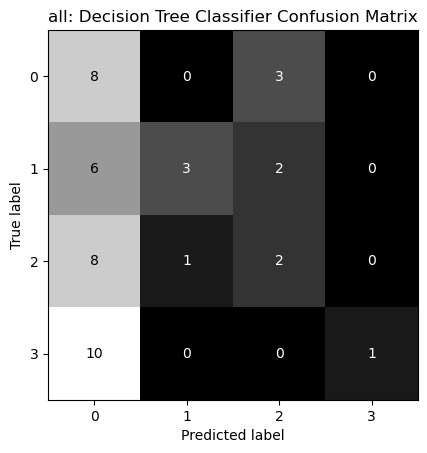

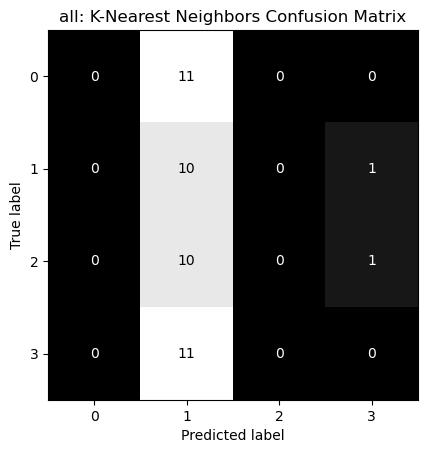

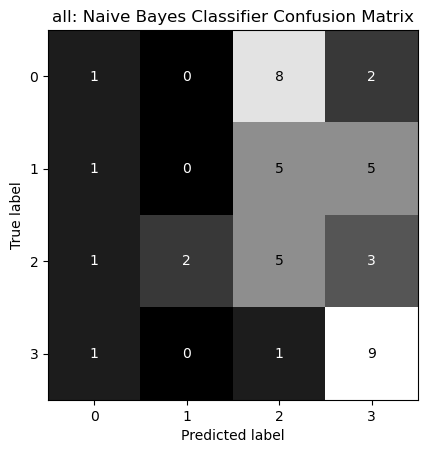

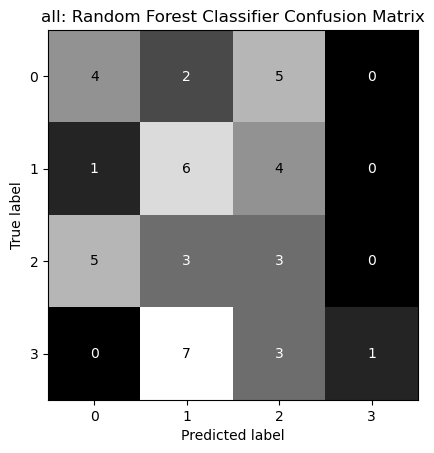

              precision    recall  f1-score   support

           0       0.14      0.09      0.11        11
           1       0.27      0.27      0.27        11
           2       0.25      0.27      0.26        11
           3       0.29      0.36      0.32        11

    accuracy                           0.25        44
   macro avg       0.24      0.25      0.24        44
weighted avg       0.24      0.25      0.24        44

              precision    recall  f1-score   support

           0       0.33      0.18      0.24        11
           1       0.43      0.55      0.48        11
           2       0.35      0.55      0.43        11
           3       0.43      0.27      0.33        11

    accuracy                           0.39        44
   macro avg       0.39      0.39      0.37        44
weighted avg       0.39      0.39      0.37        44

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.

d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


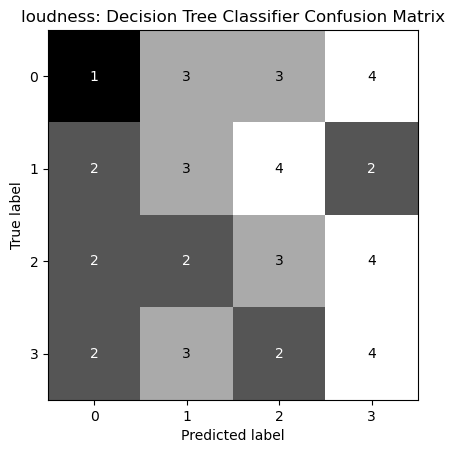

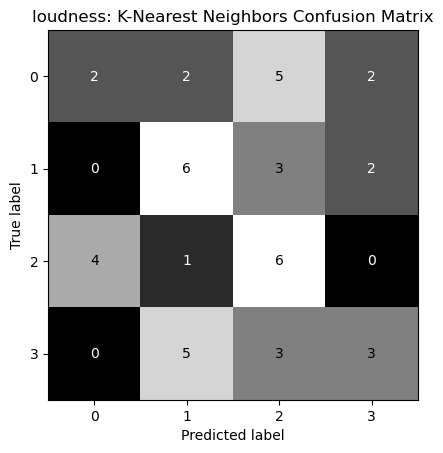

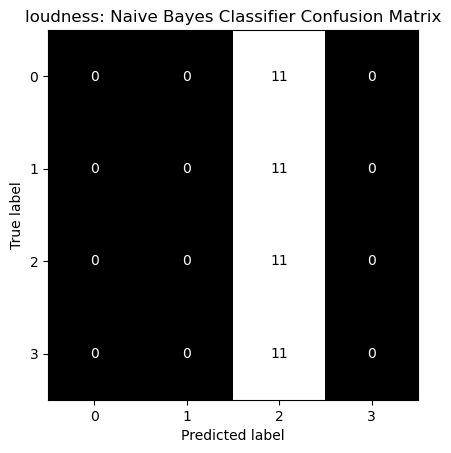

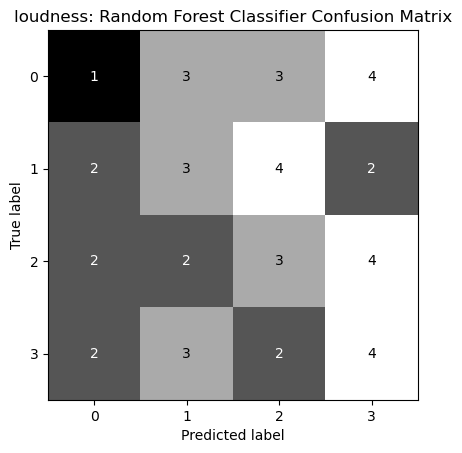

              precision    recall  f1-score   support

           0       0.36      0.36      0.36        11
           1       0.54      0.64      0.58        11
           2       0.25      0.27      0.26        11
           3       0.75      0.55      0.63        11

    accuracy                           0.45        44
   macro avg       0.48      0.45      0.46        44
weighted avg       0.48      0.45      0.46        44

              precision    recall  f1-score   support

           0       0.22      0.36      0.28        11
           1       0.33      0.18      0.24        11
           2       0.28      0.45      0.34        11
           3       0.00      0.00      0.00        11

    accuracy                           0.25        44
   macro avg       0.21      0.25      0.21        44
weighted avg       0.21      0.25      0.21        44

              precision    recall  f1-score   support

           0       0.35      0.55      0.43        11
           1       0.

d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


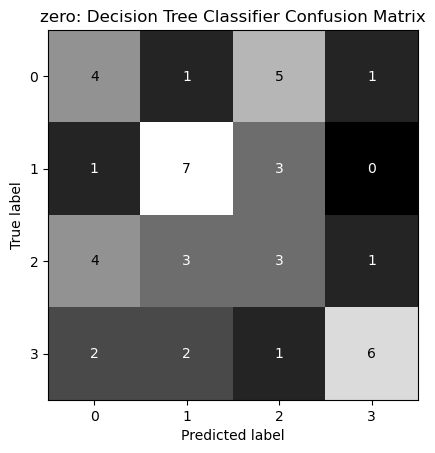

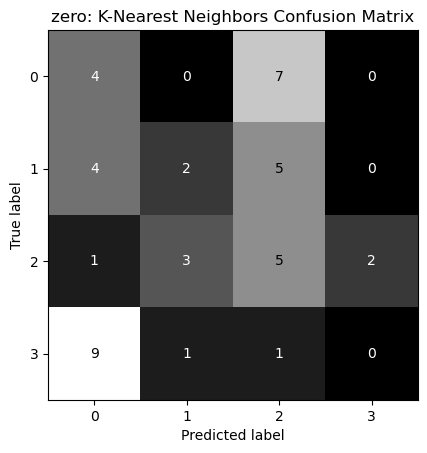

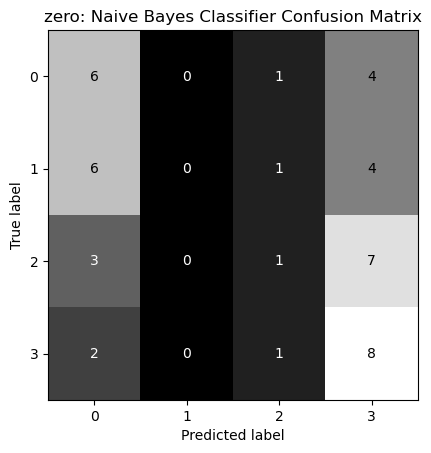

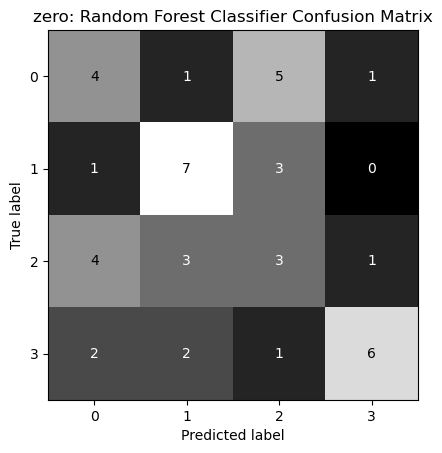

              precision    recall  f1-score   support

           0       0.40      0.18      0.25        11
           1       0.26      0.91      0.41        11
           2       1.00      0.09      0.17        11
           3       0.00      0.00      0.00        11

    accuracy                           0.30        44
   macro avg       0.42      0.30      0.21        44
weighted avg       0.42      0.30      0.21        44

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.24      0.91      0.38        11
           2       0.00      0.00      0.00        11
           3       0.33      0.09      0.14        11

    accuracy                           0.25        44
   macro avg       0.14      0.25      0.13        44
weighted avg       0.14      0.25      0.13        44

              precision    recall  f1-score   support

           0       0.25      0.09      0.13        11
           1       0.

d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\p3-librosa\lib\site-packages\

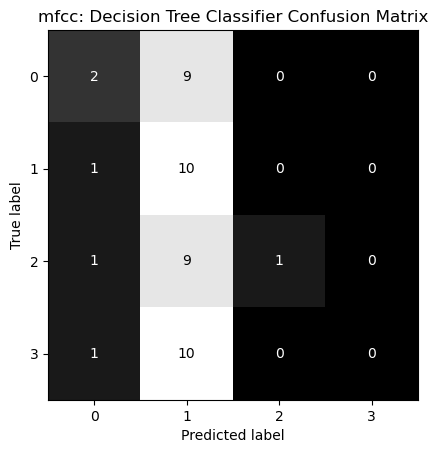

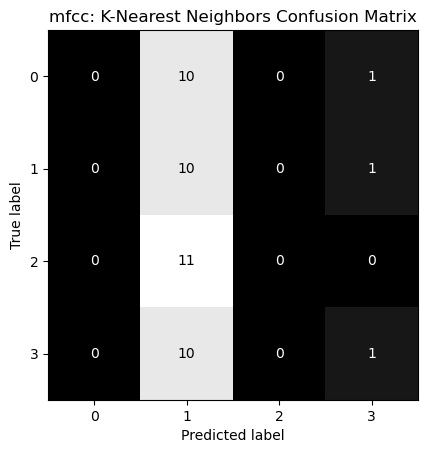

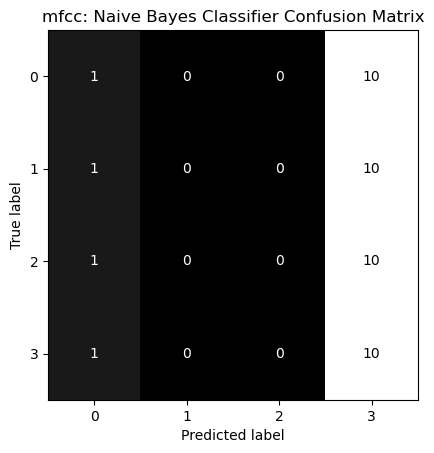

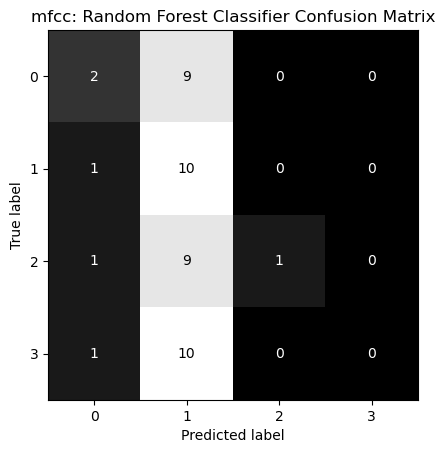

              precision    recall  f1-score   support

           0       0.50      0.09      0.15        11
           1       0.27      1.00      0.42        11
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        11

    accuracy                           0.27        44
   macro avg       0.19      0.27      0.14        44
weighted avg       0.19      0.27      0.14        44

              precision    recall  f1-score   support

           0       0.40      0.18      0.25        11
           1       0.24      0.82      0.37        11
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        11

    accuracy                           0.25        44
   macro avg       0.16      0.25      0.15        44
weighted avg       0.16      0.25      0.15        44

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.

d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\p3-librosa\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\p3-librosa\lib\site-packages\

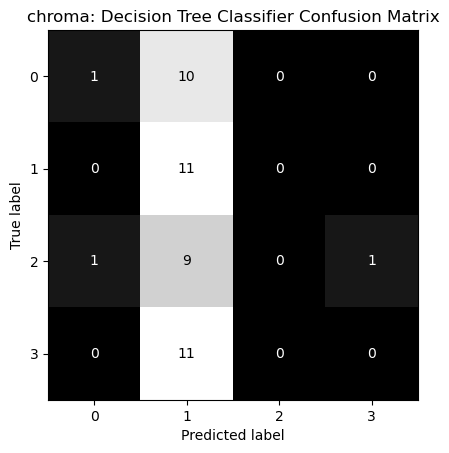

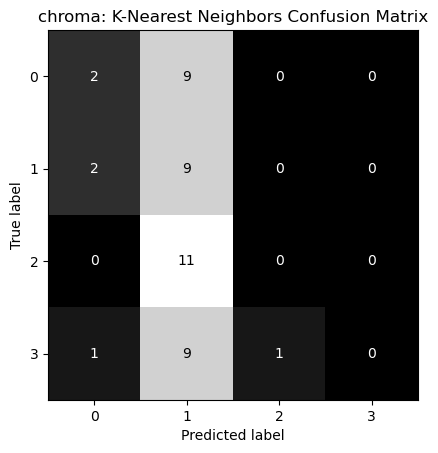

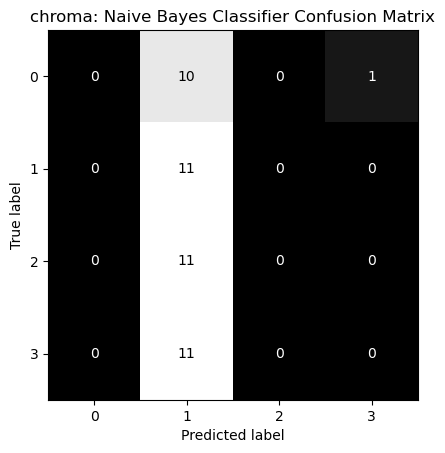

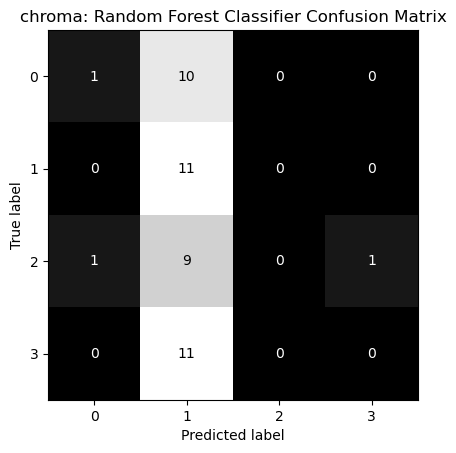

In [180]:
def fitTestTrain(x_train, x_test, y_train, y_test, title):
    dtree = DecisionTreeClassifier()
    knn = KNeighborsClassifier()
    nbc = GaussianNB() #naive bayes
    rfc = RandomForestClassifier()
    
    dtree.fit(x_train, y_train)
    knn.fit(x_train, y_train)
    nbc.fit(x_train, y_train)
    rfc.fit(x_train, y_train)
    #testing model with testing dataset
    y_dtree_predicted = dtree.predict(x_test)
    y_dtree_pred_proba = dtree.predict_proba(x_test)

    y_knn_predicted = knn.predict(x_test)
    y_knn_pred_proba = knn.predict_proba(x_test)

    y_nbc_predicted = nbc.predict(x_test)
    y_nbc_pred_proba = nbc.predict_proba(x_test)

    y_rfc_predicted = rfc.predict(x_test)
    y_rfc_pred_proba = rfc.predict_proba(x_test)

    print(classification_report(y_test, y_dtree_predicted))
    print(classification_report(y_test, y_knn_predicted))
    print(classification_report(y_test, y_nbc_predicted))
    print(classification_report(y_test, y_rfc_predicted))

    models = [title + 'Decision Tree Classifier', title + 'K-Nearest Neighbors', title + 'Naive Bayes Classifier', title + 'Random Forest Classifier']
    predictions = [y_dtree_predicted, y_knn_predicted, y_nbc_predicted, y_rfc_predicted]
    pred_probabilities = [y_dtree_pred_proba, y_knn_pred_proba, y_nbc_pred_proba, y_rfc_pred_proba]

    plot = 1

    for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
        disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
        disp.plot(
            include_values=True,
            cmap='gray',
            colorbar=False
        )
        disp.ax_.set_title(f"{model} Confusion Matrix")

    plt.show()
    
fitTestTrain(x_train, x_test, y_train, y_test, "all: ")
fitTestTrain(x_train_loud, x_test_loud, y_train_loud, y_test_loud, "loudness: ")
fitTestTrain(x_train_zero, x_test_zero, y_train_zero, y_test_zero, "zero: ")
fitTestTrain(x_train_mfcc, x_test_mfcc, y_train_mfcc, y_test_mfcc, "mfcc: ")
fitTestTrain(x_train_chroma, x_test_chroma, y_train_chroma, y_test_chroma, "chroma: ")

In [ ]:
def avgAll(data, result, type, start):  
    for j in range(0,11):
        avg = {'emotion':type, 'loudness':0 , 'zero':0, 'mfcc':0, 'chroma':0}
        div = {1:0, 2:0, 3:0, 4:0}
        for i in range(start, start+len(data.keys())):
            if j < len(data[i]["loudness"]):
                avg['loudness'] = avg['loudness'] + data[i]["loudness"][j]
                div[1] = div[1] + 1
            if j < len(data[i]["zero"]):
                avg['zero'] = avg['zero'] + data[i]["zero"][j]
                div[2] = div[2] + 1
            if j < len(data[i]["mfcc"]):
                if np.isnan(data[i]["mfcc"][j]).all() == False:
                    avg['mfcc'] = avg['mfcc'] + np.nanmean(data[i]["mfcc"][j])
                    div[3] = div[3] + 1
            if j < len(data[i]["chroma"]):
                if np.isnan(data[i]["chroma"][j]).all() == False:
                    avg['chroma'] = avg['chroma'] + np.nanmean(data[i]["chroma"][j])
                    div[4] = div[4] + 1
        div = dict(map(lambda x: (x[0], 1) if x[1] == 0 else (x[0], x[1]), div.items()))
        avg['loudness'] = avg['loudness'] / div[1]
        avg['zero'] = avg['zero'] / div[2]
        avg['mfcc'] = avg['mfcc'] / div[3]
        avg['chroma'] = avg['chroma'] / div[4]
        result.loc[len(result.index),:] = avg
    
train_final_b = pd.DataFrame(columns = ['emotion', 'loudness', 'zero', 'mfcc', 'chroma'])
avgAll(angry_train, train_final_b, 0, 0)
avgAll(fear_train, train_final_b, 1, 0)
avgAll(happy_train, train_final_b, 2, 0)
avgAll(sad_train, train_final_b, 3, 0)

test_final_b = pd.DataFrame(columns = ['emotion', 'loudness', 'zero', 'mfcc', 'chroma'])
avgAll(angry_test, test_final_b, 0, 70)
avgAll(fear_test, test_final_b, 1, 70)
avgAll(happy_test, test_final_b, 2, 70)
avgAll(sad_test, test_final_b, 3, 70)

In [ ]:
y_train = train_final['emotion'].astype('int') # dependent variable
x_train = train_final.drop(columns='emotion') # predictor variables
y_test = test_final['emotion'].astype('int') # dependent variable
x_test = test_final.drop(columns='emotion') # predictor variables

x_train_loud = train_final.loc[:,['loudness']]
y_train_loud = train_final['emotion'].astype('int')
x_test_loud = test_final.loc[:,['loudness']]
y_test_loud = test_final['emotion'].astype('int')

x_train_zero = train_final.loc[:,['zero']]
y_train_zero = train_final['emotion'].astype('int')
x_test_zero = test_final.loc[:,['zero']]
y_test_zero = test_final['emotion'].astype('int')


x_train_mfcc = train_final.loc[:,['mfcc']]
y_train_mfcc = train_final['emotion'].astype('int')
x_test_mfcc = test_final.loc[:,['mfcc']]
y_test_mfcc = test_final['emotion'].astype('int')

x_train_chroma = train_final.loc[:,['chroma']]
y_train_chroma = train_final['emotion'].astype('int')
x_test_chroma = test_final.loc[:,['chroma']]
y_test_chroma = test_final['emotion'].astype('int')